# Visually confirming that graphs are generated correctly using the package network methods

In [ ]:
# TODO: expand NW so that it includes completely disconnected tools. or confirm that it does

## Imports

In [92]:

import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops #TODO does this need to be ere?
from datetime import datetime
import igraph               # Used to create te citationa graph 
import pickle
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))

import json
import pandas as pd

import random
import math
import wfqc.data
import wfqc.network as nw
from wfqc.workflow import parse_workflows, radnomise_workflows
import wfqc.metrics

## Creating an example network with the attributes of our network

To mimic the setup of the actual data the example network has nodes that are tools, named TA, TB etc, and nodes that are citations of these tools, named CA, CB etc. Tools can cite eacother, and tools can also cite themselves, creating self loops. Citations do not cite other citations. There are fully disconnected tools in this network, that are not connected to any other tool. These discoonected tools can have many citations, or none, but are not connected to the rest of the network. Some of the disconnected tools have self loops. There are subclusters that are disconnected from eachother. Edges are not necessarily unique; the same connection can occur twice in the same network. Some citations are connected to almost all tools. 

#### Creating the edges

In [2]:
# Define the nodes
tools = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF',
        # Separate cluster
         'TG', 'TH',
        # 
         'TI']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'), ('CH', 'TH'),
    ('CI', 'TI'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    ('CM', 'TA'), ('CM', 'TB'), ('CM', 'TC'), ('CM', 'TD'), ('CM', 'TE'), 
    ('CN', 'TA'), ('CN', 'TB'), ('CN', 'TC'), ('CN', 'TD'), ('CN', 'TE'), ('CN', 'TF'),
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'), ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TD', 'TE'), ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'), ('TB', 'TB'), ('TH', 'TH'), 

    # Disconnected cluster
    ('CQ', 'TG'), ('CQ', 'TH'), ('CO', 'TH'),
    ('CO', 'TG')

    
]



In [3]:
# Define the nodes smaller
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CQ', 'TE'), ('CQ', 'TF'), ('CO', 'TE'),
    ('CO', 'TF')

    
]



#### Create graph

In [4]:
citation_graph= igraph.Graph.TupleList(edges, directed=True)

## Visualisation


#### Preview of 'raw' graph

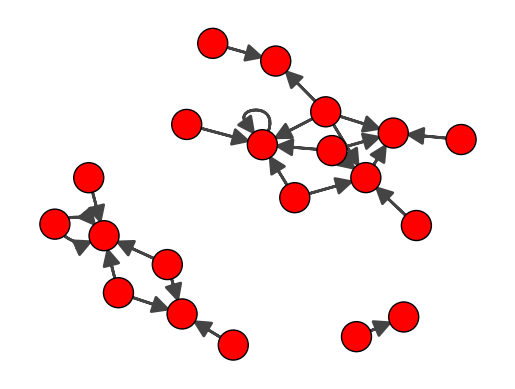

In [5]:
fig, ax = plt.subplots()
igraph.plot(citation_graph, target=ax)

#### Visually confirming that simplify works

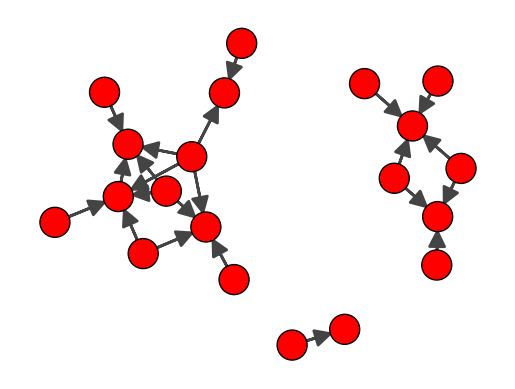

In [6]:
fig, ax = plt.subplots()

G = citation_graph.simplify(multiple=True, loops=True, combine_edges=None)

igraph.plot(G, target=ax)

#### Visually confirming cocitation_graph function

In [7]:
included_tools = [tool for tool in tools if tool in citation_graph.vs['name']] 
cocitation_graph = nw.cocitation_graph(citation_graph, included_tools)
included_tools = [tool for tool in tools if tool in cocitation_graph.vs['name']] 
print(included_tools)

['TA', 'TB', 'TC', 'TD', 'TE', 'TF']


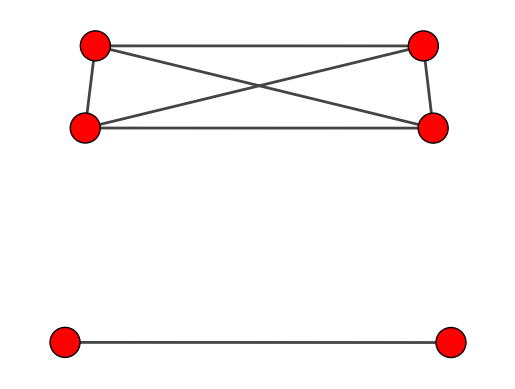

In [8]:
fig, ax = plt.subplots()
igraph.plot(cocitation_graph, target=ax)

## Or, visualising the same thing using cytoscape

In [ ]:

current_time = datetime.now().strftime("%Y%m%d%H%M")
p4c.create_network_from_igraph(citation_graph, f"citation_test_network", collection="Citation networks")

print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass([tool for tool in tools if tool in citation_graph.vs['name']], "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass([tool for tool in tools if tool in citation_graph.vs['name']], 100)  # remember it cannot be a np.array, just a list argh 


In [ ]:
vertices_to_remove = [v.index for v in citation_graph.vs if v.degree() <= 1 and v['name'] not in tools]
citation_graph.delete_vertices(vertices_to_remove)


In [ ]:

current_time = datetime.now().strftime("%Y%m%d%H%M")
p4c.create_network_from_igraph(citation_graph, f"citation_test_network", collection="Citation networks")

print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass([tool for tool in tools if tool in citation_graph.vs['name']], "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass([tool for tool in tools if tool in citation_graph.vs['name']], 100)  # remember it cannot be a np.array, just a list argh 


Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

In [ ]:
vertices_to_remove = [v.index for v in citation_graph.vs if v.degree() == 0]
citation_graph.delete_vertices(vertices_to_remove)

In [ ]:

current_time = datetime.now().strftime("%Y%m%d%H%M")
p4c.create_network_from_igraph(citation_graph, f"citation_test_network", collection="Citation networks")

print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass([tool for tool in tools if tool in citation_graph.vs['name']], "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass([tool for tool in tools if tool in citation_graph.vs['name']], 100)  # remember it cannot be a np.array, just a list argh 


Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

### Now cocitaiton

In [ ]:
current_time = datetime.now().strftime("%Y%m%d%H%M")
p4c.create_network_from_igraph(cocitation_graph, f"Cocitation_test_network", collection="Citation networks")

print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

In [ ]:
# Styling edges
p4c.set_edge_label_mapping('weight')
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('weight', mapping_type='c'))

style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

### If we want to save the example graphs

In [ ]:
citation_path = "tests/data/citation_path.pkl"
cocitation_path = "tests/data/cocitation_path.pkl"

with open(citation_path, 'wb') as f:
    pickle.dump(citation_graph, f)

with open(cocitation_path, 'wb') as f:
    pickle.dump(cocitation_graph, f)